1) tidy up code (allow generic access to environment by algorithm, internalize functions like reset, simulate)
2) add function to compute payoff (differentiate payoff and reward)
3) add logger
4) push to github
5) testing

In [1]:
import pandas as pd
import numpy as np
import itertools as it
import matplotlib.pyplot as plt

## The Environment: Stock

In [31]:
class SimpleStock:
    """Simulates a simple stock that can be traded.
    The single trader is a price taker (his transactions have no effects
    on the stock price). The only exogenous factor that affects the
    stock price is the firm's performance, which can take 3 levels.
    Firm performance in the current period affects next-period prices.
    The firm's performance over time is governed by a transition
    matrix. The stock's observable state comprises the trader's position
    in the stock, the firm performance, and price, which is indirectly 
    defined by the last-period price and growth rates.
    """
    # ========== STATES ==========
    firm_performance = [-2,-1,0,1,2]
    performance_transition_matrix = pd.DataFrame(
        [[0.40, 0.60, 0.00, 0.00, 0.00],
         [0.00, 0.40, 0.60, 0.00, 0.00],
         [0.00, 0.00, 0.10, 0.90, 0.00],
         [0.00, 0.00, 0.00, 0.40, 0.60],
         [0.60, 0.00, 0.00, 0.00, 0.40]], 
        index=firm_performance, columns=firm_performance)
    
    # stock prices can change by +/- 1 or 0 per period
    # probabilities of change are conditional on current firm performance
    # e.g. next period prices will very likely be lower if firm under-performed this period
    stock_growths = [-2, -1, 0, 1, 2]
    growth_probabilities = pd.DataFrame(
        [[1.00, 0.00, 0.00, 0.00, 0.00],
         [0.00, 0.90, 0.10, 0.00, 0.00],
         [0.00, 0.00, 0.90, 0.10, 0.00],
         [0.00, 0.00, 0.00, 0.90, 0.10],
         [0.00, 0.00, 0.00, 0.00, 1.00]], index=firm_performance, columns=stock_growths)
    
    # prices are discrete
    # controls the number of states by limiting prices
    price_bounds = [40, 60]
    
    # position = how many shares owned by the trader
    # trader cannot own negative shares and cannot own more than 10 shares
    position_bounds = [0, 10]
    # tracks the most recent purchase price (for capital gains tax calculation)
    last_buyin_price = None
    
    # unit of change in position allowed 
    # i.e. if stocks are bought or sold, must be at increments of x shares
    increment = 2
    
    # generate all observable states: performance x price x position
    states = list(it.product(firm_performance, 
                        range(price_bounds[0], price_bounds[1]+1),
                        range(position_bounds[0], position_bounds[1]+1, increment)))
    
    # ========== ACTIONS ==========
    # investor can buy or sell x shares at a time, or hold (buy 0)
    # action space = [-x, -(x-1), ..., 0, ..., x-1, x]
    # e.g. if transactions = -x, then sell x shares
    transactions = list(range(-position_bounds[1], position_bounds[1]+1, increment))
    
    # fixed transaction cost per share
    transaction_cost = 0
    
    # capital gains tax: fixed percentage of capital gain deducted
    capital_gains_tax = 0.2
    
    
    def __init__(self, initial_performance=0, initial_price=50, initial_position=0):
        """
        """
        self.performance = initial_performance
        self.price = initial_price
        self.position = initial_position
        self.growth = None
        # tracks transaction and price histories
        self.performance_history = []
        self.transaction_history = []
        self.payoff_history = []
        self.price_history = [initial_price]
        self.total_payoff = 0
    
    @property
    def price(self):
        return self.__price
    
    @price.setter
    def price(self, value):
        a, b = self.price_bounds
        if value > b:
            self.__price = b
        elif value < a:
            self.__price = a
        else:
            self.__price = value
            
    
    def payoff_calculator(self, transaction):
        """Payoffs are based on change in value of total assets.
        Buying has a payoff of 0 - transaction costs, since cash is
        converted to the value of stock minus fees. Holding while stock
        appreciates/depreciates has a payoff of the change in stock value
        between two consecutive periods. Selling has a payoff of the final
        stock value minus transaction fees and taxes.
        """
        payoff = 0
        
        # if buying
        if transaction > 0:
            payoff -= transaction * (self.price + self.transaction_cost)
        # if selling
        elif transaction < 0:
            capital_gains = abs(transaction) * (self.price - self.last_buyin_price)
            payoff -= transaction * self.price
            
            # apply capital gains tax
            taxes = (capital_gains > 0) * self.capital_gains_tax * capital_gains
            payoff -= taxes
                
        # if holding
        else:
            payoff += self.position * (self.price - self.price_history[-1])
                
        return payoff
    
    
    def is_valid_transaction(self, transaction):
        """Allows selling iff a share is already owned.
        Allows buying iff ownership limit is not reached.
        """
        if self.position + transaction > self.position_bounds[1]:
#             print(f"Cannot own more than {self.position_bounds[1]} stocks.")
            return False
        elif self.position + transaction < self.position_bounds[0]:
#             print(f"Cannot own less than {self.position_bounds[0]} stocks.")
            return False
        else:
            return True
    
    
    def investment_decision(self, transaction):
        """
        """
        # ========== CALCULATE PAYOFFS ==========
        if not self.is_valid_transaction(transaction):
            # if action is not valid, 'do nothing'
            transaction = 0
        self.transaction_history.append(transaction)
        
        # records most recent buy-in price
        if transaction > 0:
            self.last_buyin_price = self.price
            
        payoff = self.payoff_calculator(transaction)
        self.payoff_history.append(payoff)
        self.total_payoff += payoff
        
        # ========== STATE TRANSITION ==========
        self.position += transaction
        
        # select next-period price growth based on current performance
        probs = self.growth_probabilities.loc[self.performance, :].values
        self.growth = np.random.choice(self.stock_growths, p=probs)
        # calculate next-period price
        self.price_history.append(self.price)
        self.price = self.price + int(self.growth)
        
        # select next-period performance
        self.performance_history.append(self.performance)
        probs = self.performance_transition_matrix.loc[self.performance, :].values
        self.performance = np.random.choice(self.firm_performance, p=probs)
        
        state = (self.performance, self.price, self.position)
        
        return state, payoff
    

### Test Environment

In [ ]:
stock = SimpleStock()
day = 0
N = 1
actions = [0]
# actions = [1] + [0]*(N-1)
# actions = np.random.choice([-1, 0, 1], size=N, replace=True)
for i in range(N):
    print(f"=====Day {day}=====")
    print(f"Performance: {stock.performance}, Price: {stock.price}, Growth: {stock.growth}")
    state, payoff = stock.investment_decision(actions[i])
    transaction = stock.transaction_history[-1]
    print("Transaction =", transaction, ", Position =", stock.position)
    print("Last Buy-in Price =", stock.last_buyin_price, ", Payoff = $", payoff)
    day += 1
    
plt.plot(stock.performance_history)
plt.axhline(y=0)

In [ ]:
plt.plot(stock.price_history)

## Q-Learning Algorithm

In [3]:
def stable_softmax(x, axis=1):
    """ Numerically stable softmax:
    softmax(x) = e^x /(sum(e^x))
               = e^x / (e^max(x) * sum(e^x/e^max(x)))
    Args:
        x: A 1-dimensional array of floats
    Returns:
        output: softmax(x)
    """
    z = np.exp(x - np.max(x))
    output = z / np.sum(z)

    return output

In [32]:
initial_state = (0, 50, 0)
current_state = initial_state
stock = SimpleStock(*initial_state)

a, b = len(stock.states), len(stock.transactions)
Q_HAT = np.zeros(shape=(a,b))
print(Q_HAT.shape)
i_to_state = {i:j for i,j in enumerate(stock.states)}
state_to_i = {j:i for i,j in enumerate(stock.states)}
i_to_action = {i:j for i,j in enumerate(stock.transactions)}
action_to_i = {j:i for i,j in enumerate(stock.transactions)}

(630, 11)


In [34]:
%%time
alpha = 1.0
gamma = 1
min_trading_days = 30
num_iters = 2000
trials = []

for i in range(num_iters):
#     print(f"========== ITERATION {i} ==========")
    
    # keep trading until minimum days elapsed and position is cleared
    day = 0
    while day < min_trading_days or stock.position != 0:
        
        Q_row = Q_HAT[state_to_i[current_state]]
        
        if all(Q_row == 0):
            transaction = np.random.choice(stock.transactions)
        else:
            # choosing action using softmax policy
            probs = stable_softmax(Q_row)
            transaction = np.random.choice(stock.transactions, p=probs)
            
            # choosing action using hardmax policy
#             transaction = i_to_action[np.argmax(Q_row)]

        # obtain payoff from this state and transition to next state
        next_state, payoff = stock.investment_decision(transaction)
        day += 1
        
        # update Q table
        new_value = payoff + gamma * np.max(Q_HAT[state_to_i[next_state]])
        j, k = state_to_i[current_state], action_to_i[transaction]
        Q_HAT[j, k] += alpha * (new_value - Q_HAT[j, k])
        
        current_state = next_state
    
    # save current environment
    trials.append(stock)
    
    # reset environment
    p = np.random.choice(range(45,55+1))
    s = np.random.choice([-2, -1, 0, 1, 2])
    current_state = (s, p, 0)
    stock = SimpleStock(*current_state)

CPU times: total: 22.1 s
Wall time: 22.3 s


## Analyze Results

In [43]:
total_payoffs = []
for trial in trials:
    total_payoffs.append(trial.total_payoff)
print(np.mean(total_payoffs), np.round(np.min(total_payoffs),3), np.round(np.max(total_payoffs),3))
recent = total_payoffs[-int(0.3*len(total_payoffs)):]
print(np.mean(recent), np.round(np.min(recent),3), np.round(np.max(recent),3))

12.643800000000002 -154.0 206.8
10.308000000000003 -3.2 57.6


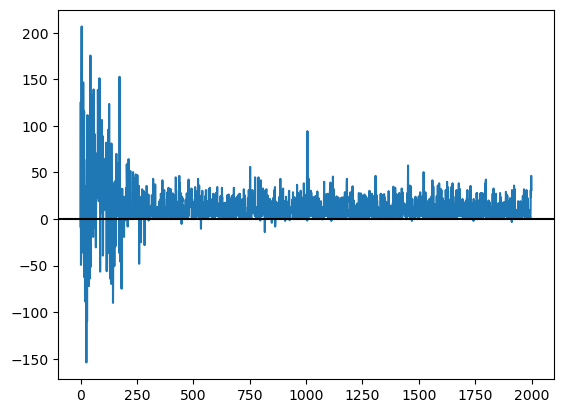

In [44]:
plt.plot(total_payoffs[:])
plt.axhline(y=0, c="black")

### Single Trial

In [67]:
def plot_trial(trial):
    fig, ax1 = plt.subplots()
    ax1.set_title(f"Total Payoff: {trial.total_payoff}")
    ax1.plot(trial.price_history[1:], c="BLACK")
    ax1.set_ylabel("Price")
    ax1.set_xlabel("Day")
    
    y = max(trial.price_history)
    
    for i,t in enumerate(trial.transaction_history):
        if t > 0:
            ax1.axvline(x=i, c="BLUE", ls=":")
            ax1.text(x=i+0.2, y=y, s=t)
        if t < -1:
            ax1.axvline(x=i, c="RED", ls=":")
            ax1.text(x=i+0.2, y=y, s=t)
            
    ax2 = ax1.twinx()
    ax2.bar(x=range(len(trial.performance_history)), height=trial.performance_history, alpha=0.6)
    ax2.set_ylim(-2,24)
    ax2.axhline(y=0, c="black")

In [ ]:
np.where(np.array(total_payoffs) < 0)

In [38]:
# np.where(np.array(total_payoffs) > 4)

In [49]:
pos = np.where(np.array(total_payoffs) > int(max(total_payoffs)*0.7))[0]
pos

array([  5,  12,  44,  84, 173], dtype=int64)

Perf. 1 Price 47 Trans. 0 Payoff 0
Perf. 2 Price 48 Trans. 0 Payoff 0
Perf. -2 Price 50 Trans. 0 Payoff 0
Perf. -2 Price 48 Trans. 0 Payoff 0
Perf. -1 Price 46 Trans. 0 Payoff 0
Perf. -1 Price 45 Trans. 0 Payoff 0
Perf. 0 Price 44 Trans. 0 Payoff 0
Perf. 1 Price 44 Trans. 0 Payoff 0
Perf. 2 Price 45 Trans. 0 Payoff 0
Perf. -2 Price 47 Trans. 0 Payoff 0
Perf. -1 Price 45 Trans. 0 Payoff 0
Perf. -1 Price 44 Trans. 0 Payoff 0
Perf. 0 Price 43 Trans. 0 Payoff 0
Perf. 1 Price 43 Trans. 0 Payoff 0
Perf. 2 Price 44 Trans. 10 Payoff -440
Perf. 2 Price 46 Trans. 0 Payoff 20
Perf. 2 Price 48 Trans. -4 Payoff 188.8
Perf. 2 Price 50 Trans. 0 Payoff 12
Perf. 2 Price 52 Trans. 0 Payoff 12
Perf. -2 Price 54 Trans. 0 Payoff 12
Perf. -1 Price 52 Trans. 0 Payoff -12
Perf. 0 Price 51 Trans. 4 Payoff -204
Perf. 0 Price 51 Trans. 0 Payoff 0
Perf. 1 Price 51 Trans. 0 Payoff 0
Perf. 1 Price 52 Trans. -4 Payoff 207.2
Perf. 2 Price 53 Trans. 0 Payoff 6
Perf. -2 Price 55 Trans. 0 Payoff 12
Perf. -1 Price 53 Tra

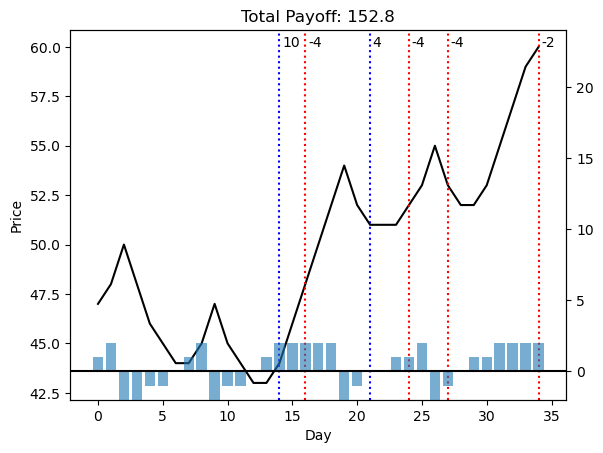

In [68]:
_id = 173
for i,j,k,l in zip(trials[_id].performance_history,
                 trials[_id].price_history[1:],
                 trials[_id].transaction_history, 
                 trials[_id].payoff_history):
    print("Perf.",i, "Price",j, "Trans.",k, "Payoff",l)
plot_trial(trials[_id])

In [69]:
view = pd.DataFrame(Q_HAT, 
                    index=pd.MultiIndex.from_tuples(stock.states, names=["perf.", "price", "pos."]), 
                    columns=stock.transactions)
view

-10    -8     -6   -4     -2    0     2    4      6      8   \
perf. price pos.                                                                
-2    40    0     0.0    0.0    0.0  0.0  172.4  0.0 -80.0  0.0 -234.0 -320.0   
            2     0.0    0.0    0.0  0.0    0.0  0.0   0.0  0.0   84.0    0.0   
            4     0.0    0.0    0.0  0.0  162.0  0.0   0.0  0.0    0.0    0.0   
            6     0.0    0.0  284.0  0.0    0.0  0.0   0.0  0.0    0.0    0.0   
            8     0.0  336.8    0.0  0.0    0.0  0.0   0.0  0.0    0.0    0.0   
...               ...    ...    ...  ...    ...  ...   ...  ...    ...    ...   
 2    60    2     0.0    0.0    0.0  0.0  285.6  0.0   0.0  0.0    0.0    0.0   
            4     0.0    0.0    0.0  0.0  403.2  0.0   0.0  0.0    0.0    0.0   
            6     0.0  538.8    0.0  0.0    0.0  0.0   0.0  0.0    0.0    0.0   
            8     0.0    0.0    0.0  0.0  376.4  0.0   0.0  0.0    0.0    0.0   
            10    0.0    0.0  626.4  0.0    0.0  0.0   0.0  0.0    0.0    0.0   

                   10  
perf. price pos.       
-2    40    0     0.0  
            2     0.0  
            4     0.0  
            6     0.0  
            8     0.0  
...               ...  
 2    60    2     0.0  
            4     0.0  
            6     0.0  
            8     0.0  
            10    0.0  

[630 rows x 11 columns]

In [70]:
# view[view.index.isin(list(range(50,55)), level="price")]
view[view.index.isin([0], level="perf.") & view.index.isin([0], level="pos.")]

-10    -8     -6     -4     -2      0      2      4   \
perf. price pos.                                                           
0     40    0     151.2    0.0    0.0    0.0    0.0    5.2  -80.0 -160.0   
      41    0       0.0    5.2    0.0  175.6    0.0    0.0  -82.0 -164.0   
      42    0       0.0    5.2    0.0    0.0   81.6    0.0    0.0  -40.4   
      43    0       0.8  178.8    0.0    3.2    5.2    0.0    0.0 -172.0   
      44    0       0.0    0.8    0.0    8.4  178.8    0.0  -86.0 -176.0   
      45    0       5.2    0.0    0.0    0.0    3.6   19.2  -70.0 -180.0   
      46    0     182.0    0.8    3.2    3.2    5.2    0.0  -90.0 -184.0   
      47    0       0.0    2.8  170.8    0.0    5.2    0.0    0.0    0.0   
      48    0       0.0    0.0   78.4    3.2    0.0    5.2  -90.0 -192.0   
      49    0       1.2    0.0    0.0    5.2  172.4    0.0  -94.0   -4.4   
      50    0       0.0    0.0    0.0  188.4    5.2    0.0   -2.8 -200.0   
      51    0       0.0    0.0  115.6    0.0    0.0    4.8 -102.0   -0.8   
      52    0       0.4    0.0  188.4    0.0    0.0    1.6  -94.0  -83.2   
      53    0     242.4    4.4    1.6    0.0    0.4    1.6  -88.0 -102.4   
      54    0       0.0    0.4    0.0    1.6    1.6  203.2 -106.0 -104.0   
      55    0       0.0  164.0    0.4    0.4    0.0    0.0 -110.0 -100.0   
      56    0       0.0    0.0    0.0    0.0    0.0  174.4 -106.0 -224.0   
      57    0     173.2    0.0    1.6    3.6    1.6    0.0 -112.0 -228.0   
      58    0     240.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
      59    0       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
      60    0       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                     6      8      10  
perf. price pos.                       
0     40    0    -240.0    0.0 -400.0  
      41    0    -246.0 -328.0 -232.8  
      42    0     -84.0 -336.0 -246.8  
      43    0    -246.0    0.0 -430.0  
      44    0    -258.0 -344.0  -68.0  
      45    0    -270.0 -328.0  -88.0  
      46    0    -270.0  -69.2 -460.0  
      47    0    -282.0 -278.4 -470.0  
      48    0     -88.8    0.0  -91.6  
      49    0    -288.0    0.0    0.0  
      50    0    -300.0   -1.6 -292.0  
      51    0      -1.2 -200.0 -510.0  
      52    0    -100.0 -204.0 -108.4  
      53    0       0.0 -416.0 -302.4  
      54    0    -197.2 -318.0 -540.0  
      55    0    -330.0 -292.0 -520.0  
      56    0    -312.0 -324.8 -560.0  
      57    0    -342.0 -456.0 -570.0  
      58    0       0.0    0.0    0.0  
      59    0       0.0    0.0    0.0  
      60    0       0.0    0.0    0.0

## Random Policy (Benchmark)

In [ ]:
%%time
rnd_total_payoffs = []

for i in range(num_iters):
    stock = SimpleStock()
    day = 0

    # keep trading until minimum days elapsed and position is cleared
    while day < min_trading_days or stock.position != 0:)
        transaction = np.random.choice([-1, 0, 1])
        state, payoff = stock.investment_decision(transaction)
        transaction = stock.transaction_history[-1]
        day += 1
        
    rnd_total_payoffs.append(stock.total_payoff)

In [ ]:
m = np.mean(rnd_total_payoffs)
print(m)
plt.plot(rnd_total_payoffs)
plt.axhline(y=m, c="black")